Notebook purpose

- Explore coffee purchasing patterns

In [2]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

# add custom packages to sys.path and import
sys.path.append("/Users/fgu/dev/projects/habits")
import habits.helpers.aws as aws

# pandas options
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)

# ipython magic
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# plot settings
sns.set_context("talk")

# project dirs
INDIR = "s3://fgu-data-mdb/clean"
OUTDIR = "s3://fgu-project-habits/clean"
FIGDIR = "/Users/fgu/dev/projects/habits/reports/figures"

SAMPLE = "777"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare data

In [5]:
def read_sample(sample):
    """Read clean data for sample."""
    fp = f"s3://3di-data-mdb/clean/mdb_{SAMPLE}.parquet"
    return aws.s3read_parquet(fp)


df = read_sample(SAMPLE)
print(df.shape)
df.head(2)

(682656, 28)


,id,date,user_id,amount,desc,merchant,tag_up,user_female,user_lsoa,user_msoa,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,credit_debit,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_recorded_balance,merchant_business_line,tag_auto,tag_manual,updated_flag
0,688261,2012-01-03,777,-400.00,<mdbremoved> - s/o,no merchant,other account,False,e01012553,e02002603,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,debit,2014-07-18,2017-11-13,True,364.22,non merchant mbl,transfers,other account,u
1,688264,2012-01-03,777,-10.27,"9572 30dec11 , mcdonalds , restaurant , winwick road gb - pos",mcdonalds,dining and drinking,False,e01012553,e02002603,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,debit,2014-07-18,2015-03-19,True,364.22,mcdonalds,dining and drinking,no tag,u


In [7]:
def clean_data(df):
    """Prepare data for analysis"""
    # keep txns with description only
    df = df.dropna(subset=["desc"])

    # tag coffee purchases
    re = "coffee|cafe|caffe|cafè|costa|starbucks|nero"
    df["coffee"] = df.desc.str.contains(re)

    return df


def main(df):
    df = clean_data(df)
    return df


df = main(df)
df.head(2)

,id,date,user_id,amount,desc,merchant,tag_up,user_female,user_lsoa,user_msoa,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,credit_debit,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_recorded_balance,merchant_business_line,tag_auto,tag_manual,updated_flag,coffee
0,688261,2012-01-03,777,-400.00,<mdbremoved> - s/o,no merchant,other account,False,e01012553,e02002603,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,debit,2014-07-18,2017-11-13,True,364.22,non merchant mbl,transfers,other account,u,False
1,688264,2012-01-03,777,-10.27,"9572 30dec11 , mcdonalds , restaurant , winwick road gb - pos",mcdonalds,dining and drinking,False,e01012553,e02002603,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,debit,2014-07-18,2015-03-19,True,364.22,mcdonalds,dining and drinking,no tag,u,False


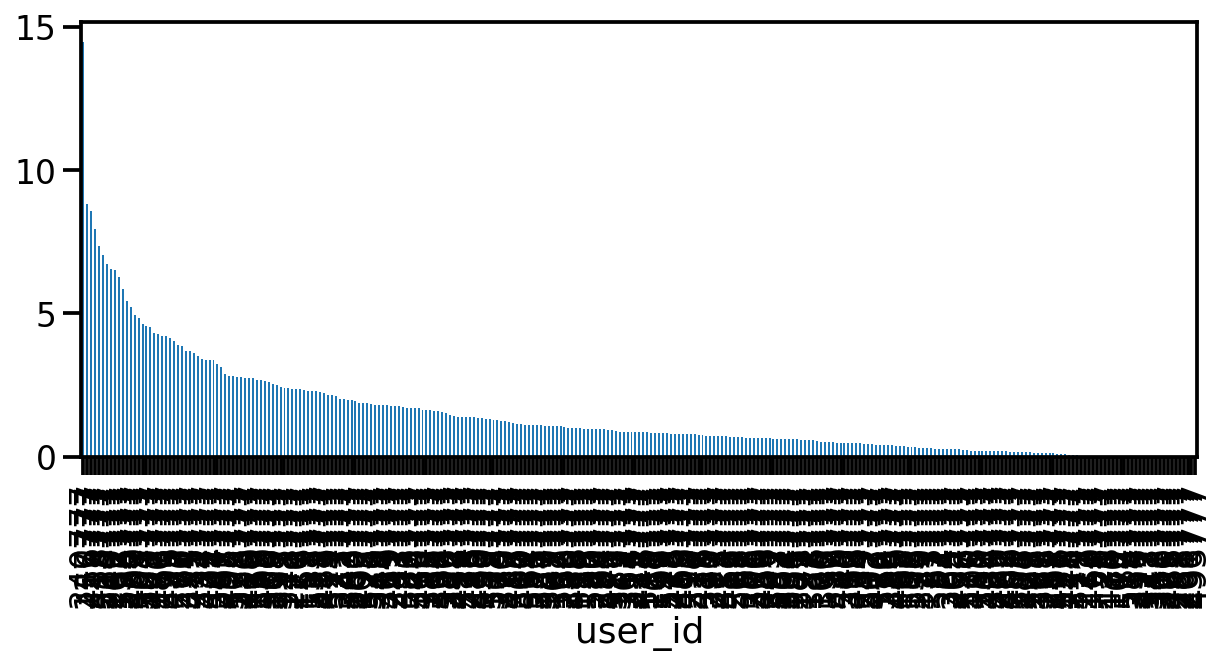

In [8]:
(
    df.groupby("user_id")
    .coffee.agg([("obs", "count"), ("coffee", "sum")])
    .assign(share=lambda df: df.coffee / df.obs * 100)
    .share.sort_values(ascending=False)
).plot(kind="bar", figsize=(10, 4));